In [97]:
import matplotlib.pyplot as plt
from math import cos,sqrt,pi
from tqdm import tqdm
import numpy as np
import cv2 as cv
import os

# This command will output the existing images
# print(os.listdir(BASE_DIR))
BASE_DIR = "../data/Hw4/standard_test_images/"

GRAY_IMG_LIST = ["cameraman.tif", 
                 "house.tif", 
                 "jetplane.tif",
                 "lake.tif", 
                 "lena_gray_256.tif", 
                 "lena_gray_512.tif", 
                 "livingroom.tif", 
                 "mandril_gray.tif", 
                 "peppers_gray.tif", 
                 "pirate.tif", 
                 "walkbridge.tif", 
                 "woman_blonde.tif", 
                 "woman_darkhair.tif"]

COLOR_IMG_LIST = ["lena_color_256.tif", "lena_color_512.tif", "mandril_color.tif", "peppers_color.tif"]

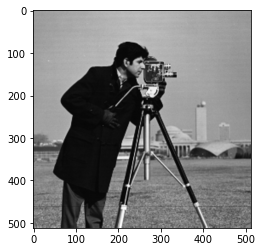

In [70]:
GRAY_IMG = GRAY_IMG_LIST[0]
GRAY_IMG = cv.imread(BASE_DIR+GRAY_IMG)
plt.imshow(GRAY_IMG)
plt.show()

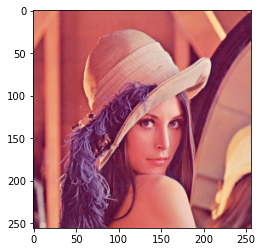

In [53]:
COLOR_IMG = COLOR_IMG_LIST[0]
COLOR_IMG = cv.imread(BASE_DIR+COLOR_IMG)
COLOR_IMG = cv.cvtColor(COLOR_IMG, cv.COLOR_BGR2RGB)

plt.imshow(COLOR_IMG)
plt.show()

In [80]:
def RGB_to_YCbCr(COLOR_IMG):
    """    
    Y = 0.299 R + 0.587 G + 0.114 B
    Cb = - 0.1687 R - 0.3313 G + 0.5 B + 128
    Cr = 0.5 R - 0.4187 G - 0.0813 B + 128
    """
    
    W, H, C = COLOR_IMG.shape
    YCbCr_IMG = np.zeros((W, H, C))
    
    for w in range(W):
        for h in range(H):
            YCbCr_IMG[w,h,0] = + 0.2990*COLOR_IMG[w,h,0] + 0.5870*COLOR_IMG[w,h,1] + 0.1140*COLOR_IMG[w,h,2] +   0
            YCbCr_IMG[w,h,1] = - 0.1687*COLOR_IMG[w,h,0] - 0.3313*COLOR_IMG[w,h,1] + 0.5000*COLOR_IMG[w,h,2] + 128
            YCbCr_IMG[w,h,2] = + 0.5000*COLOR_IMG[w,h,0] - 0.4187*COLOR_IMG[w,h,1] - 0.0813*COLOR_IMG[w,h,2] + 128
    
    return YCbCr_IMG

def YCbCr_to_RGB(YCbCr_IMG):
    """
    R = Y + 1.402 (Cr-128)
    G = Y - 0.34414 (Cb-128) - 0.71414 (Cr-128)
    B = Y + 1.772 (Cb-128)
    """
    
    W, H, C = YCbCr_IMG.shape
    COLOR_IMG = np.zeros((W, H, C), np.uint8) # Avoid floating points
    
    for w in range(W):
        for h in range(H):
            COLOR_IMG[w,h,0] = YCbCr_IMG[w,h,0] + 1.40200*(YCbCr_IMG[w,h,2]-128)
            COLOR_IMG[w,h,1] = YCbCr_IMG[w,h,0] - 0.34414*(YCbCr_IMG[w,h,1]-128) - 0.71414*(YCbCr_IMG[w,h,2]-128)
            COLOR_IMG[w,h,2] = YCbCr_IMG[w,h,0] + 1.77200*(YCbCr_IMG[w,h,1]-128)
            
    return COLOR_IMG
            
YCbCr_IMG = RGB_to_YCbCr(COLOR_IMG)
COLOR_IMG_INV = YCbCr_to_RGB(YCbCr_IMG)

In [83]:
def Downsample_YCbCr(YCbCr_IMG):
    """
    Y  ==> Remain the same
    Cb ==> Cut down 50%
    Cr ==> Cut down 50%
    """
    W, H, C = YCbCr_IMG.shape
    CW = W//2
    CH = H//2
    Y_Channel = YCbCr_IMG[:,:,0]
    Cb_Channel= np.zeros((CW, CH))
    Cr_Channel= np.zeros((CW, CH))
    
    # In a 2x2 grid, directly use the top-left pixel
    for w in range(CW):
        for h in range(CH):
            Cb_Channel[w,h]=YCbCr_IMG[2*w,2*h,1]
            Cr_Channel[w,h]=YCbCr_IMG[2*w,2*h,2]
    
    return Y_Channel, Cb_Channel, Cr_Channel

def Upsample_YCbCr(IDCT_RESULT):
    pass

Y_Channel, Cb_Channel, Cr_Channel = Downsample_YCbCr(YCbCr_IMG)

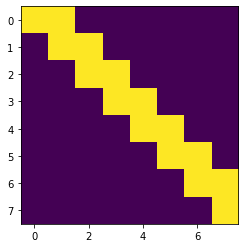

100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<?, ?it/s]


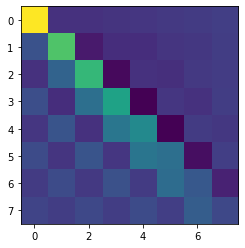

100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 8019.70it/s]


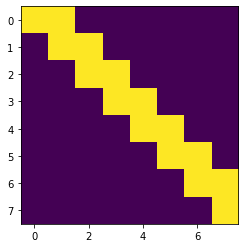

In [113]:
'''
沿用 HW3 的 Code
This class is used to perform Discrete Cosine Transform
REF: https://github.com/AbraaoHonorio/DCT-Discrete-Cosine-Transform
'''

class Github_Cosine_Transform():
    
    def __init__(self):
        pass

    def dct_2d(self, image, numberCoefficients=0):

        nc = numberCoefficients # passando para NC para melhorar a visibilidade da formula
        height = image.shape[0]
        width = image.shape[1]
        imageRow = np.zeros_like(image).astype(float)
        imageCol = np.zeros_like(image).astype(float)

        for h in tqdm(range(height)):
            imageRow[h, :] = self.dct_1d(image[h, :], nc) # aplicando IDCT na linhas
        for w in tqdm(range(width)):
            imageCol[:, w] = self.dct_1d(imageRow[:, w], nc) # aplicando IDCT nas colunas

        return imageCol

    def dct_1d(self, image, numberCoefficients=0):

        nc = numberCoefficients
        n = len(image)
        newImage= np.zeros_like(image).astype(float)


        for k in range(n):
            sum = 0
            for i in range(n):
                sum += image[i] * cos(2 * pi * k / (2.0 * n) * i + (k * pi) / (2.0 * n))
            ck = sqrt(0.5) if k == 0 else 1
            newImage[k] = sqrt(2.0 / n) * ck * sum

        # salvando os N maiores numeros e zerandos todos os outros
        if nc > 0:
            newImage.sort()
            for i in range(nc, n):
                newImage[i] = 0

        return newImage # retorno de um VETOR


    def idct_2d(self, image):
        height = image.shape[0]
        width =  image.shape[1]
        imageRow = np.zeros_like(image).astype(float)
        imageCol = np.zeros_like(image).astype(float)


        for h in tqdm(range(height)):
            imageRow[h, :] = self.idct_1d(image[h, :]) # aplicando IDCT na linhas
        for w in tqdm(range(width)):
            imageCol[:, w] = self.idct_1d(imageRow[:, w]) # aplicando IDCT nas colunas

        return imageCol

    def idct_1d(self, image):

        n = len(image)
        newImage = np.zeros_like(image).astype(float)

        for i in range(n):
            sum = 0
            for k in range(n):
                ck = sqrt(0.5) if k == 0 else 1 # operador tenario para verificar o valor do CK
                sum += ck * image[k] * cos(2 * pi * k / (2.0 * n) * i + (k * pi) / (2.0 * n))

            newImage[i] = sqrt(2.0 / n) * sum

        return newImage
    
"""
link:http://www.robertstocker.co.uk/jpeg/jpeg_new_9.htm

Thanks to Teacher's link, I re-implemented the demo 8x8 block
in order to test whether my DCT methods is okay or not.
"""
TEST_BLOCK_01 = np.array([[5, 5, 64, 64, 5, 5, 5, 5],
                         [5, 5, 64, 64, 5, 5, 5, 5],
                         [5, 5, 64, 64, 5, 5, 5, 5],
                         [5, 5, 64, 64, 5, 5, 5, 5],
                         [5, 5, 64, 64, 5, 5, 5, 5],
                         [5, 5, 64, 64, 5, 5, 5, 5],
                         [5, 5, 64, 64, 5, 5, 5, 5],
                         [5, 5, 64, 64, 5, 5, 5, 5],])

TEST_BLOCK_02 = np.array([[ 5,  5,  5,  5,  5,  5,  5,  5],
                          [ 5,  5,  5,  5,  5,  5,  5,  5],
                          [64, 64, 64, 64, 64, 64, 64, 64],
                          [64, 64, 64, 64, 64, 64, 64, 64],
                          [ 5,  5,  5,  5,  5,  5,  5,  5],
                          [ 5,  5,  5,  5,  5,  5,  5,  5],
                          [ 5,  5,  5,  5,  5,  5,  5,  5],
                          [ 5,  5,  5,  5,  5,  5,  5,  5],])

TEST_BLOCK_03 = np.array([[64, 64,  5,  5,  5,  5,  5,  5],
                          [ 5, 64, 64,  5,  5,  5,  5,  5],
                          [ 5,  5, 64, 64,  5,  5,  5,  5],
                          [ 5,  5,  5, 64, 64,  5,  5,  5],
                          [ 5,  5,  5,  5, 64, 64,  5,  5],
                          [ 5,  5,  5,  5,  5, 64, 64,  5],
                          [ 5,  5,  5,  5,  5,  5, 64, 64],
                          [ 5,  5,  5,  5,  5,  5,  5, 64],])

# Step 1: Choose Test Block
TEST_BLOCK = TEST_BLOCK_03
plt.imshow(TEST_BLOCK)
plt.show()

# Step 2: Perform DCT on Test Block
DCT_Tool = Github_Cosine_Transform()
DCT_BLOCK = DCT_Tool.dct_2d(TEST_BLOCK)
plt.imshow(DCT_BLOCK)
plt.show()

# Step 3: (Optional) Inverse DCT
INV_DCT_BLOCK = DCT_Tool.idct_2d(DCT_BLOCK)
plt.imshow(INV_DCT_BLOCK)
plt.show()

In [143]:
def Quantization(Block, MODE):
    """
    This is the point at which I can control the quality.
    I decided to follow Nikon Camera's setting
    """
    
    if MODE == "Y":

        QT_Y = np.array([[ 2,  1,  1,  1,  1,  1,  2,  1],
                         [ 1,  1,  2,  2,  2,  2,  2,  4],
                         [ 3,  2,  2,  2,  2,  5,  4,  4],
                         [ 3,  4,  6,  5,  6,  6,  6,  5],
                         [ 6,  6,  6,  7,  9,  8,  6,  7],
                         [ 9,  7,  6,  6,  8, 11,  8,  9],
                         [10, 10, 10, 10, 10,  6,  8, 11],
                         [12, 11, 10, 12,  9, 10, 10, 10]])
        
        Block_Y_Qtzd = np.zeros((8,8))
        Block_Y_Qtzd = Block / QT_Y
        
        return Block_Y_Qtzd.astype(np.int8)
    
    elif MODE == "Cb" or MODE == "Cr":
        
        QT_C = np.array([[ 2,  2,  2,  2,  2,  2,  5,  3],
                         [ 3,  5, 10,  7,  6,  7, 10, 10],
                         [10, 10, 10, 10, 10, 10, 10, 10],
                         [10, 10, 10, 10, 10, 10, 10, 10],
                         [10, 10, 10, 10, 10, 10, 10, 10],
                         [10, 10, 10, 10, 10, 10, 10, 10],
                         [10, 10, 10, 10, 10, 10, 10, 10],
                         [10, 10, 10, 10, 10, 10, 10, 10]])

        Block_C_Qtzd= np.zeros((8,8))
        Block_C_Qtzd= Block/ QT_C
    
        return Block_C_Qtzd.astype(np.int8)
    
    else:
        print("QAQ")
        
def DeQuantization(Block_Qtzd, MODE):
    if MODE == "Y":

        QT_Y = np.array([[ 2,  1,  1,  1,  1,  1,  2,  1],
                         [ 1,  1,  2,  2,  2,  2,  2,  4],
                         [ 3,  2,  2,  2,  2,  5,  4,  4],
                         [ 3,  4,  6,  5,  6,  6,  6,  5],
                         [ 6,  6,  6,  7,  9,  8,  6,  7],
                         [ 9,  7,  6,  6,  8, 11,  8,  9],
                         [10, 10, 10, 10, 10,  6,  8, 11],
                         [12, 11, 10, 12,  9, 10, 10, 10]])
        
        Block = np.zeros((8,8))
        Block_Y = Block_Qtzd * QT_Y
        
        return Block_Y
    
    elif MODE == "Cb" or MODE == "Cr":
        
        QT_C = np.array([[ 2,  2,  2,  2,  2,  2,  5,  3],
                         [ 3,  5, 10,  7,  6,  7, 10, 10],
                         [10, 10, 10, 10, 10, 10, 10, 10],
                         [10, 10, 10, 10, 10, 10, 10, 10],
                         [10, 10, 10, 10, 10, 10, 10, 10],
                         [10, 10, 10, 10, 10, 10, 10, 10],
                         [10, 10, 10, 10, 10, 10, 10, 10],
                         [10, 10, 10, 10, 10, 10, 10, 10]])

        Block = np.zeros((8,8))
        Block_C = Block_Qtzd* QT_C
    
        return Block_C
    
    else:
        print("QAQ")

Quantization(DCT_BLOCK, MODE="Cb")

array([[75, -5, -4, -4, -3, -2,  0,  0],
       [ 3, 19, -2, -1, -1, -1,  0,  0],
       [ 0,  2,  8, -3,  0, -1,  0,  0],
       [ 0, -1,  3,  7, -3,  0, -1,  0],
       [ 0,  1,  0,  3,  5, -3,  0,  0],
       [ 0,  0,  1,  0,  3,  3, -2,  0],
       [ 0,  0,  0,  1,  0,  2,  1, -1],
       [ 0,  0,  0,  0,  0,  0,  1,  0]], dtype=int8)

In [ ]:
def ZigzagScan(Block):
    
    order_matrix = np.array([[]])